In [1]:
# TODO: set to true to compute BP positions from raw data

recompute = False

In [2]:
import micromagneticdata as mdata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch

In [3]:
import discretisedfield as df

In [4]:
import ast
from multiprocessing import Pool
import os

In [5]:
import matplotlib
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['font.size'] = 12

In [6]:
def locate(filename):
    m = df.Field.from_file(filename)

    info = df.tools.count_bps(m)

    coarse = ast.literal_eval(info['bp_pattern_x'])[0][1] * 2.5e-9
    info['loc_x_coarse'] = coarse

    dx = 20e-9
    m_small = m.sel(x=(coarse - dx, coarse + dx))
    
    em_div = df.tools.emergent_magnetic_field(m_small).div

    loc = (em_div * em_div.mesh.coordinate_field()).integrate() / em_div.integrate()

    info['loc_fine'] = loc


    return info

In [7]:
if recompute:
    name = 'mbp_l_1500_w_100_ht_10_ixxxx'

    for j in [5e11, 1e11, 1.5e11, 2e11, 3e11, 5e11, 7e11, 1e12, 2e12]:
        drive = mdata.Data(name=name, dirname=f'simulations/J_{j:g}')[0]
        with Pool(len(os.sched_getaffinity(0))) as p:  # use all available CPUs
            res = p.map(locate, drive._step_files)

        converted = {
            'bp_number': [elem['bp_number'] for elem in res],
            'bp_number_hh': [elem['bp_number_hh'] for elem in res],
            'bp_number_tt': [elem['bp_number_tt'] for elem in res],
            'loc_x_coarse': [elem['loc_x_coarse'] for elem in res],
            'loc_x_fine': [elem['loc_fine'][0] for elem in res],
            'loc_y_fine': [elem['loc_fine'][1] for elem in res],
        }

        import pandas as pd

        pd.DataFrame(converted).to_csv(f"bp-position-j-{J * 1e9:g}.csv", index=False)

In [8]:
drive = mdata.Data(name="mbp_l_1500_w_100_ht_10_ixxxx", dirname=f'J_5e+11')[0]

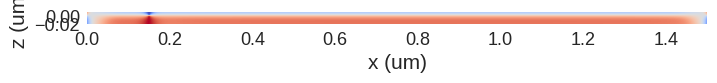

In [9]:
drive.m0.sel('y').orientation.z.mpl.scalar(colorbar=False, clim=(-1, 1), cmap='coolwarm')

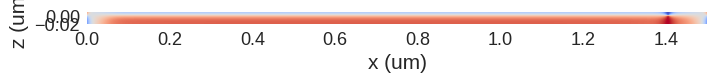

In [10]:
# only steps 0 and 1999 are saved, they can be accessed with index 0 and 1

drive[1].sel('y').orientation.z.mpl.scalar(colorbar=False, clim=(-1, 1), cmap='coolwarm')

In [11]:
js = list(reversed([50, 100, 150, 200, 300, 500, 700, 1000, 2000]))

In [12]:
def pos_time(ax, ins=False):
    vs = []

    xmin = 500e-9
    xmax = 1100e-9
    for J in js:
        res = pd.read_csv(f"bp-position-j-{J*1e9:g}.csv")
        
        tt = res['t'].to_numpy()
        xx_coarse = res['loc_x_coarse'].to_numpy()

        handle, = ax.plot(tt * 1e9, xx_coarse * 1e9, label=f'J={J/1000} × 10¹²')

        imin = np.argmin(xx_coarse < xmin)
        imax = np.argmin(xx_coarse < xmax)
        if imax == 0 and xx_coarse[-1] > xmin:
            imax = len(xx_coarse) - 1

        try:
            poly = np.polynomial.Polynomial.fit(tt[imin:imax], xx_coarse[imin:imax], deg=1)

            vs.append(poly.convert().coef[1])
            ax.plot(tt * 1e9, poly(tt) * 1e9, linestyle=':', color=handle.get_color())
        except ValueError:
            vs.append(0)
    ax.axhline(xmin * 1e9, linestyle='--', c='grey')
    ax.axhline(xmax * 1e9, linestyle='--', c='grey')
    ax.set_ylim((0, 1500))
    ax.set_xlim((-.5, 25))
    ax.set_xlabel('t (ns)')
    ax.set_ylabel('x (nm)')
    if not ins:
        ax.legend(frameon=True, loc='lower right')
    ax.grid()
    return vs

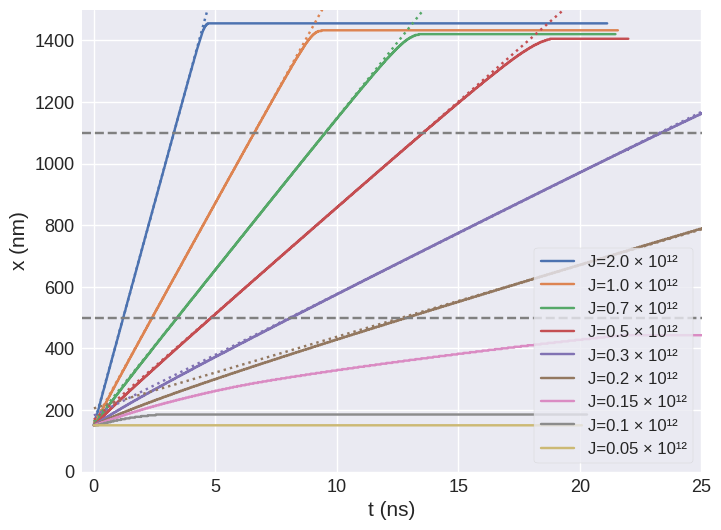

In [13]:
fig, ax = plt.subplots()
vs = pos_time(ax)

In [14]:
res = pd.read_csv('bp-position-j-5e+11.csv')

In [15]:
locations = res[["loc_x_fine", "loc_y_fine"]].to_numpy() * 1e9
locations.shape

(2199, 2)

In [16]:
combined = df.Field.from_file('tt-hh-combined.h5')
combined.valid = 'norm'

Text(0, 310, 'd')

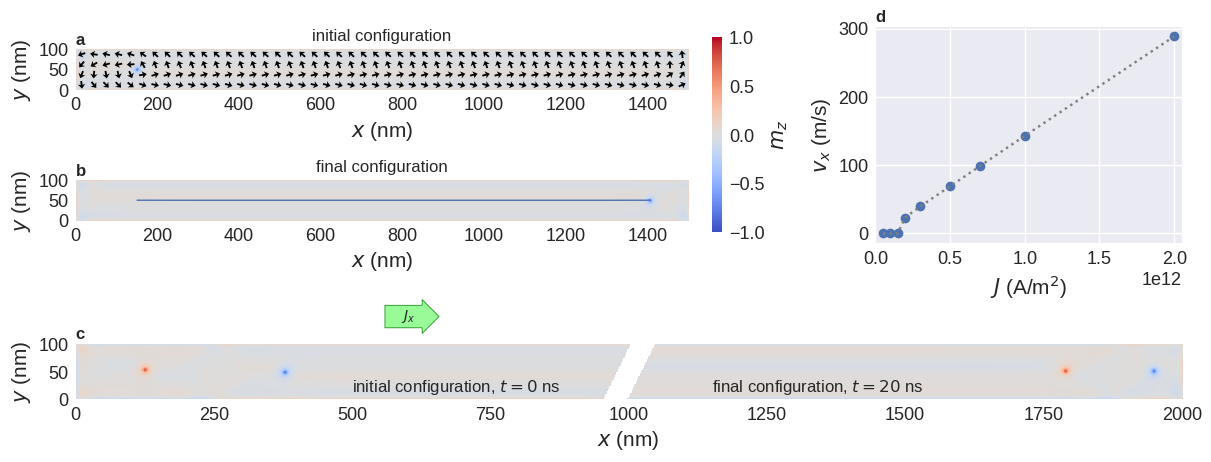

In [17]:
layout = """
is
fs
dd
"""
fig, axs = plt.subplot_mosaic(layout, figsize=(12, 4.5), width_ratios=[10, 5], layout='constrained')

#vs = pos_time(axs['p'])

ax = axs['i']
drive.m0.sel(z=1e-9).orientation.z.mpl.scalar(colorbar=False, ax=ax, clim=(-1, 1), cmap='coolwarm', multiplier=1e-9)
drive.m0.sel(z=1e-9).resample((50, 4)).orientation.mpl.vector(ax=ax, use_color=False, scale=80, multiplier=1e-9, headlength=2.5, headaxislength=2, width=0.003, headwidth=4)
ax.set_title('initial configuration', fontsize='medium')
ax.set_xlabel('$x$ (nm)')
ax.set_ylabel('$y$ (nm)')

ax = axs['f']
drive[1].sel(z=1e-9).orientation.z.mpl.scalar(colorbar=False, ax=ax, clim=(-1, 1), cmap='coolwarm', multiplier=1e-9)
ax.set_title('final configuration', fontsize='medium')
ax.plot(locations[:, 0], locations[:, 1], linewidth=1)
ax.set_xlabel('$x$ (nm)')
ax.set_ylabel('$y$ (nm)')

fig.colorbar(axs['i'].images[0], ax=[axs['i'], axs['f']], label=r'$m_z$', pad=-0.05, fraction=0.05, shrink=0.9)

ax = axs['s']
ax.plot(np.array(js) * 1e9, vs, 'o')
ax.plot(np.array(js) * 1e9, vs, ':', c='grey')
ax.set_xlabel('$J$ (A/m$^2$)')
ax.set_ylabel('$v_x$ (m/s)')
ax.grid()
ax.set_xlim((0, 2.05e12))

ax = axs['d']
combined.sel(z=1e-9).orientation.z.mpl.scalar(ax=ax, clim=(-1, 1), cmap='coolwarm', multiplier=1e-9, colorbar=False)
ax.set_facecolor("white")
ax.text(500, 15, 'initial configuration, $t=0$ ns')
ax.text(1150, 15, 'final configuration, $t=20$ ns')
ax.set_xlabel('$x$ (nm)')
ax.set_ylabel('$y$ (nm)')

ax.text(600, 150, "    $J_x$    ", ha="center", va="center", rotation=0, size=10, bbox=dict(boxstyle="rarrow,pad=0.2", fc="palegreen", ec="green", lw=.5))


axs['i'].text(0, 110, 'a', fontweight='bold')
axs['f'].text(0, 110, 'b', fontweight='bold')
axs['d'].text(0, 110, 'c', fontweight='bold')
axs['s'].text(0, 310, 'd', fontweight='bold')


In [18]:
fig.savefig('Fig2.pdf')